# Age prediction females with informative region

Final jupyter notebook for age prediction using infrared spectrosocpy data from tsetse females with the informative region

## Changelog

### 2023-11-03

#### Modified

- Deleted non-used code
- Plots have been renamed


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization
from utilities import variable_importance_df

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
tsetse_females_thorax = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Head')]

In [7]:
tsetse_females_thorax.groupby("Age")["ID"].count()

Age
3d    136
5w     96
7w    122
Name: ID, dtype: int64

In [8]:
tsetse_females_head.groupby("Age")["ID"].count()

Age
3d    133
5w     92
7w    120
Name: ID, dtype: int64

In [9]:
tsetse_females_thorax_copy = tsetse_females_thorax.copy()
tsetse_females_head_copy = tsetse_females_head.copy()

## Age prediction females

In [10]:
X_thorax = tsetse_females_thorax.loc[:,"1800":"602"]
y_thorax = tsetse_females_thorax.loc[:,"Age"]

X_head = tsetse_females_head.loc[:,"1800":"602"]
y_head = tsetse_females_head.loc[:,"Age"]

In [11]:
waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [12]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [13]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [14]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

In [15]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.700000  0.035515
1        LR  0.839286  0.053240
2        RF  0.785714  0.058926
3       SVC  0.778571  0.056595


In [16]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.694737  0.052436
1        LR  0.845614  0.042008
2        RF  0.729825  0.068797
3       SVC  0.728070  0.058039


In [17]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)

Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [18]:
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [19]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [20]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.8405797101449275
Accuracy on test set: 0.9014084507042254


In [21]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"

In [28]:
report_head.to_excel("../results/tables/informative_region_results/accuracy_age_females_head.xlsx")

In [22]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"

In [23]:
report_age_females_informative = pd.concat([report_head,report_thorax])
report_age_females_informative.to_excel("../results/tables/informative_region_results/accuracy_age_females_info.xlsx")

In [24]:
# top wavenumbers

topwavenumbers = variable_importance_df(wavenumbers_reduced,best_mdoel_thorax)
topwavenumbers

,Wavenumbers,Coefficients
15,1770,7.787661
14,1772,7.015233
6,1788,6.834660
512,776,4.116736
357,1086,4.055370
358,1084,4.026268
118,1564,3.542068
16,1768,3.483096
513,774,3.448821
359,1082,3.300049


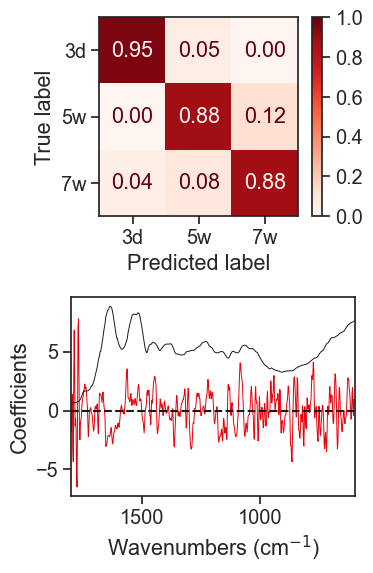

In [31]:
# final plot
# coefficients and confusion matrix for thorax

sn.set(font_scale=1.3)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*30), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1800,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


#for i in range(0, 20):
 #   ax2.axvline(topwavenumbers.iloc[i,0], color='r', alpha=0.5)

plt.savefig("../results/plots/Fig5_age_females_head_informative.png", dpi=900)

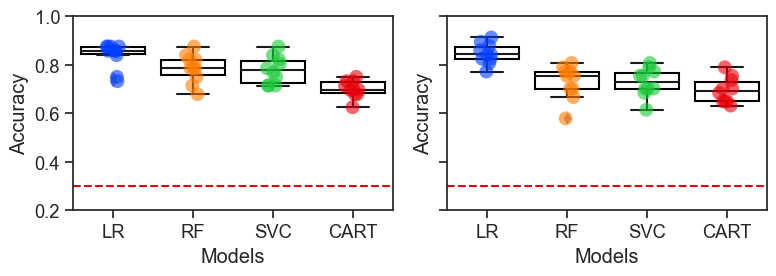

In [32]:
# training plots
# confucion matrix for the head

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax3)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True, sharey=True)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax3,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax3.lines, color='k')
ax3.axhline(0.3, color='r',ls='--')
ax3.set_ylim(0.2,1)
ax3.set_xlabel("Models")
ax3.set_ylabel("Accuracy")
for i,box in enumerate(ax3.patches):
    box.set_edgecolor('black')

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.3, color='r',ls='--')
ax.set_ylim(0.2,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')

plt.savefig("../results/plots/females_age_training_informative_suplementary.png", dpi=900)


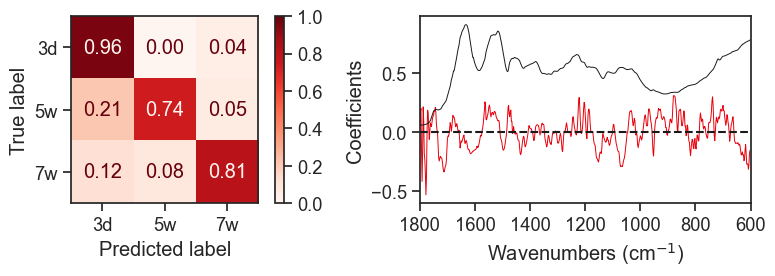

In [33]:
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_model_head['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*3), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1800,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


plt.savefig("../results/plots/age_females_head_informative_suplementary.png", dpi=300)
